In [1]:
from sklearn import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Загрузка и препроцессинг данных

In [2]:
train_filename = "cust_class_train.csv"
test_filename = "cust_class_test.csv"

In [3]:
train_data = pd.read_csv(train_filename)
test_data = pd.read_csv(test_filename)

In [4]:
train_data = train_data.set_index("ID")
test_data = test_data.set_index("ID")

In [5]:
train_data.Ever_Married = train_data.Ever_Married.astype('category')
train_data.Graduated = train_data.Graduated.astype('category')
train_data.Profession = train_data.Profession.astype('category')
train_data.Spending_Score = train_data.Spending_Score.astype('category')
train_data.Var_1 = train_data.Var_1.astype('category')
train_data.Segmentation = train_data.Segmentation.astype('category')

In [6]:
drop_rows = train_data[
    (train_data.Age < train_data.Age.quantile(0.005)) | 
    (train_data.Age > train_data.Age.quantile(0.995))].index

In [7]:
train_data = train_data.drop(drop_rows)

In [8]:
train_data.Work_Experience = train_data.Work_Experience.fillna(0)
train_data.Family_Size = train_data.Family_Size.fillna(1)
train_data.Ever_Married = train_data.Ever_Married.fillna(train_data.Ever_Married.mode()[0])
train_data.Graduated = train_data.Graduated.fillna(train_data.Graduated.mode()[0])
train_data.Profession = train_data.Profession.fillna(train_data.Profession.mode()[0])
train_data.Var_1 = train_data.Var_1.fillna(train_data.Var_1.mode()[0])

In [9]:
train_data.Gender = pd.factorize(train_data.Gender)[0]
train_data.Ever_Married = pd.factorize(train_data.Ever_Married)[0]
train_data.Graduated = pd.factorize(train_data.Graduated)[0]
train_data = pd.concat((train_data, pd.get_dummies(train_data.Profession)), axis=1)
train_data = train_data.drop(['Profession'], axis=1)
train_data = pd.concat((train_data, pd.get_dummies(train_data.Spending_Score)), axis=1)
train_data = train_data.drop(['Spending_Score'], axis=1)
train_data = pd.concat((train_data, pd.get_dummies(train_data.Var_1)), axis=1)
train_data = train_data.drop(['Var_1'], axis=1)

In [10]:
train_data.loc[:, train_data.columns != 'Segmentation'] = (
    train_data.loc[:, train_data.columns != 'Segmentation'] - \
    train_data.loc[:, train_data.columns != 'Segmentation'].mean(axis = 0)) / \
    train_data.loc[:, train_data.columns != 'Segmentation'].std(axis = 0)

In [11]:
X = train_data.drop(['Segmentation'], axis=1)

In [12]:
y = train_data.Segmentation

In [13]:
mapping = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3}
y = y.map(lambda x: mapping[x])

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 42)

<h2> Random Forest </h2>

In [35]:
n_trees = list(range(1, 100))

In [49]:
rf_result = pd.DataFrame(index=n_trees, columns=["MSE_train", "MSE_test", "OOB"])

In [50]:
for n in n_trees:
    classifier = ensemble.RandomForestClassifier(n_estimators=n, oob_score = True)
    classifier.fit(X_train, y_train)
    mse_train = classifier.score(X_train, y_train)
    mse_test = classifier.score(X_test, y_test)
    oob_error = classifier.oob_score_
    rf_result = rf_result.append(pd.Series({"MSE_train" : mse_train, "MSE_test" : mse_test, 'OOB' : oob_error}, name = n))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

In [51]:
rf_result

,MSE_train,MSE_test,OOB
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
95,0.956673,0.473606,0.479416
96,0.956507,0.468127,0.481242
97,0.956673,0.470618,0.485226
98,0.956673,0.471116,0.486056


<AxesSubplot:>

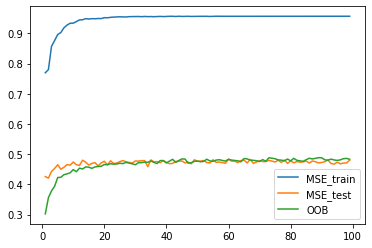

In [52]:
rf_result.plot()

<h2> Gradient Boosting Classifier </h2>

In [53]:
gb_result = pd.DataFrame(index=n_trees, columns=["MSE_train", "MSE_test"])

In [55]:
for n in n_trees:
    classifier = ensemble.GradientBoostingClassifier(n_estimators=n, loss = 'exponential')
    classifier.fit(X_train, y_train)
    mse_train = classifier.score(X_train, y_train)
    mse_test = classifier.score(X_test, y_test)
    gb_result = gb_result.append(pd.Series({"MSE_train" : mse_train, "MSE_test" : mse_test}, name = n))

ValueError: ExponentialLoss requires 2 classes; got 4 class(es)